In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import tidynamics as tid
import os

from copy import deepcopy
from time import time
from numba import njit

In [10]:
# create simulation class

class Polymer:
    
    def __init__(self,
                 n_beeds: int = 10,
                 r_beed: float = 1.0,
                 q_beed: float = 2.08,
                 bonds: list = None,
                 mobility: float = 0.002,
                 force_constant_nn: float = 100.0,
                 epsilon_LJ: float = 0.25,
                 sigma_LJ: float = 2.0,
                 lB_debye: float = 3.077,
                 c_S: float = 10,
                 cutoff_debye: float = 4.0,
                 pbc: bool = True):
    
        self.n_beeds = n_beeds
        self.r_beed = r_beed
        self.q_beed = q_beed
        self.mobility = mobility
        self.force_constant_nn = force_constant_nn
        self.epsilon_LJ = epsilon_LJ
        self.sigma_LJ = sigma_LJ
        self.lB_debye = lB_debye # units of beed radii
        self.c_S = c_S # salt concentration [c_S] = mM
        self.cutoff_debye = cutoff_debye
        self.pbc = pbc
        self.bonds = bonds       
        
        self.r0_beeds = 2*r_beed
        self.box_length = 2*r_beed*n_beeds*1.5 # make box length 1.5 times chain length (arbitrary)
        self.A_debye = self.q_beed**2*self.lB_debye
        self.B_debye = 1/(r_beed*38.46153*self.c_S) # 1/(debye screening length) in units of beed radius
        
        self.positions = np.zeros((n_beeds, 3))
        self.positions_new = np.zeros((n_beeds, 3))
        self.velocities = np.zeros((n_beeds, 3))
        self.forces = np.zeros((n_beeds, 3))
        self.energy = 0
        self.trajectory = np.zeros((1, n_beeds, 3)) # first dim is the frame
        self.distances_bonded = list(())
        self.directions_bonded = list(())
        self.distances = list(())
        self.directions = list(())
        self.cm_trajectory = None
    
    
    def create_chain(self, axis=0):
        """
        create linear chain along specified axis
        """
        
        for k in range(self.n_beeds):
            self.positions[k, axis] = k*self.r0_beeds
        
        #center chain around 0
        if self.n_beeds != 1:
            self.positions[:, axis] -= self.r0_beeds*(self.n_beeds-1)/2

        # set first trajecory frame to initial position
        self.trajectory[0,:,:] = deepcopy(self.positions)
        
        self.get_bonds()
        
        return
    
    def create_test_chain(self, sigma=0.05, axis=0):
        """
        create linear chain along x-axis
        """
        
        for k in range(self.n_beeds):
            self.positions[k, axis] = k*self.r0_beeds
        
        #center chain around 0
        if self.n_beeds != 1:
            self.positions[:, axis] -= self.r0_beeds*(self.n_beeds-1)/2
        
        # to test forces
        self.positions += np.random.randn(self.n_beeds, 3)*sigma

        # set first trajecory frame to initial position
        self.trajectory[0,:,:] = deepcopy(self.positions)
        
        self.get_bonds()
        
        return
    
    def get_bonds(self):
        """
        create list of bond pairs
        """
        #define bonds
        if self.bonds is None: 
            # if bonds are not already defined, create chain
            self.bonds =list(())
            self.bonds.append((0,1))
            for k in range(1, self.n_beeds-1):
                self.bonds.append((k, k-1))
                self.bonds.append((k, k+1))
            self.bonds.append((self.n_beeds-1, self.n_beeds-2))
            
            self.bonds = np.array(self.bonds)
        
        # calculate distances and directions for every bond tuple
        self.get_distances_directions()
        
        return
    
    def get_distances_directions(self):
        """
        get distances and directions for every bond
        """
        # TODO: CHANGE THIS SO ALL DISTANCES ARE CALCULATED ONCE AND BONDED ONES ARE INDEXED BY BONDS
        
        self.distances_bonded = list(()) # reset
        self.directions_bonded = list(()) 
        # TODO: remove double calculation
        for bond in self.bonds:
            
            r_vec = self.positions[bond[1]] - self.positions[bond[0]]
            r = np.sqrt(np.dot(r_vec, r_vec))
            #r = np.linalg.norm(r_vec)
            
            self.distances_bonded.append(r)
            self.directions_bonded.append(r_vec/r)
        
        self.distances_bonded = np.array(self.distances_bonded)
        self.directions_bonded = np.array(self.directions_bonded)
        
        return

    def get_forces(self):
        """
        this naively adds all the occuring forces, without caring about double calculations
        """
        
        #delete old forces
        self.forces = np.zeros((self.n_beeds, 3))
        
        self.force_NearestNeighbours()
        self.force_LennardJones_cutoff()
        self.force_Debye()
        
        return

    def get_forces_test(self):
        """
        for testing the forces
        """
        print("Position")
        print(self.positions)
        
        #delete old forces
        self.forces = np.zeros((self.n_beeds, 3))
        self.force_NearestNeighbours()
        print("nearest neighbours")
        print(self.forces)
        
        self.forces = np.zeros((self.n_beeds, 3))
        self.force_LennardJones()
        print("Lennard Jones")
        print(self.forces)
        
        self.forces = np.zeros((self.n_beeds, 3))
        self.force_Debye()
        print("Debye")
        print(self.forces)
        
        return
    
    
    def force_NearestNeighbours(self):
        """
        harmonice nearest neighhbour interactions
        """
        
        # calculate the force of every bond at once
        f_temp = 2*self.force_constant_nn*(self.distances_bonded-self.r0_beeds)
        
        for k, beed_idx in enumerate(self.bonds[:, 0]):
            #print(k, beed_idx)
            self.forces[beed_idx, :] += f_temp[k]*self.directions_bonded[k]
        
        return
    
    def force_LennardJones(self):
        """
        LJ nearest neighhbour interactions
        """
        f_temp = 4*self.epsilon_LJ*(-12*self.sigma_LJ**12/self.distances_bonded**13 + 6*self.sigma_LJ**7/self.distances_bonded**7)
        
        for k, beed_idx in enumerate(self.bonds[:, 0]):
            #print(k, beed_idx)
            self.forces[beed_idx, :] += f_temp[k]*self.directions_bonded[k]
        
        return
    
    def force_LennardJones_cutoff(self):
        """
        LJ interactions using a cutoff
        """
        
        cutoff = 2*self.r_beed

        for i in range(self.n_beeds-1):
            for j in range(i+1, self.n_beeds):
                r_vec = self.positions[j] - self.positions[i]
                r = np.sqrt(np.dot(r_vec, r_vec))
                
                if r < cutoff:
                    f_temp = 4*self.epsilon_LJ*(-12*self.sigma_LJ**12/r**14 + 6*self.sigma_LJ**7/r**8)
                    self.forces[i, :] += f_temp*r_vec
                    self.forces[j, :] -= f_temp*r_vec
            
        return
    
    def force_Debye(self):
        """
        non bonded interaction (debye screening)
        """
        
        for i in range(self.n_beeds-1):
            for j in range(i+1, self.n_beeds):
                r_vec = self.positions[j] - self.positions[i]
                r = np.sqrt(np.dot(r_vec, r_vec))
                
                if r < self.cutoff_debye:
                    # the 1/r**2 factor comes from the normalisation of the direction vector
                    f_temp = -self.A_debye*(1+self.B_debye*r)*np.exp(-self.B_debye*r)/r**3
                    self.forces[i, :] += f_temp*r_vec
                    self.forces[j, :] -= f_temp*r_vec
        
        return 

    
    def force_Random(self):
        
        # since the variance of the foce should be sqrt(6*mu) but the variance of the absolute randn vector is sqrt(3)
        # the variance used here is sqrt(2*mu)
        # self.forces += np.sqrt(2*self.mobility)*np.random.randn(self.n_beeds, 3)
        
        return np.sqrt(2*self.mobility)*np.random.randn(self.n_beeds, 3)
    
    
    def analytical_potential_function(self, r=None):
        
        if r is None:
            r = np.linspace(self.r0_beeds-self.r_beed,self.r0_beeds+self.r_beed, 100)
        
        L_s = 1/(38.46153*self.c_S)
        
        u_nn = self.force_constant_nn*(r-self.r0_beeds)**2
        u_LJ = 4*self.epsilon_LJ*(self.sigma_LJ**12/r**12 - self.sigma_LJ**7/r**6 + 1)
        u_Deb = self.A_debye*np.exp(-self.B_debye*r)/r
        
        # apply cutoff
        u_LJ[r>2*self.r_beed] = 0
        u_Deb[r>self.cutoff_debye] = 0
   
        return r, u_nn + u_LJ + u_Deb
    
    def get_CM_trajectory(self):
        
        traj_cm = list(())

        #calculate trajectory for center of mass
        for frame in self.trajectory:
            traj_cm.append(np.sum(frame, axis=0))
            
        self.cm_trajectory = np.array(traj_cm)/self.n_beeds
            
        return 
    
    def get_CM_MSD(self, plot=False):
        
        # TODO: write this bs properly with class internal variables
        
        if self.cm_trajectory is None:
            self.get_CM_trajectory()
            traj_cm = self.cm_trajectory
        else:
            traj_cm = self.cm_trajectory
        
        msd_tid = tid.msd(traj_cm)
        msd_tid_x = tid.msd(traj_cm[:,0])
        msd_tid_y = tid.msd(traj_cm[:,1])
        msd_tid_z = tid.msd(traj_cm[:,2])
        
        n_frames = len(traj_cm)
        t = np.arange(n_frames)

        if plot is True:
            plt.figure()
            plt.loglog(t[1:], 2*t[1:]*self.mobility, label=r"$2t\tilde{\mu}_0$", linestyle="--")
            plt.loglog(t[1:], 6*t[1:]*self.mobility, label=r"$6t\tilde{\mu}_0$", linestyle="--")
            plt.loglog(t[1:], msd_tid[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}^2\rangle$")
            plt.loglog(t[1:], msd_tid_x[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}_x^2\rangle$")
            plt.loglog(t[1:], msd_tid_y[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}_y^2\rangle$")
            plt.loglog(t[1:], msd_tid_z[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}_z^2\rangle$")
            plt.xlabel(r"$t/\Delta t$")
            plt.ylabel("MSD (center of mass)")
            plt.legend()
            plt.show()
            
        return
    
    def plot_distance_distribution(self, n_bins=100, bin_interval=None):
    
        distances_nn = list(())
        # for every frame calculate the distance between neighbouring atoms is the chain
        for frame in self.trajectory:
            distances_nn.append(np.sqrt(np.sum((frame[:self.n_beeds-1] - frame[1:])**2, axis=1)))

        distances_nn = np.array(distances_nn).ravel()
        
        if bin_interval is None:
            bin_interval = (np.min(distances_nn), np.max(distances_nn))

        # create normalized histogram
        histogram_nn, edges_nn = np.histogram(distances_nn, bins=n_bins, range=bin_interval, density=True)
        
        r, E_pot = self.analytical_potential_function(edges_nn[:n_bins])
        E_pot_normalize = np.sum((edges_nn[1:]-edges_nn[:n_bins])*np.exp(-E_pot))

        plt.figure()
        plt.plot(r, histogram_nn, label=r"$p(\Delta\tilde{r})$")
        plt.plot(r, np.exp(-E_pot)/E_pot_normalize, label=r"$\frac{1}{Z}\mathrm{exp}\{-\tilde{U}(\tilde{\Delta r})\}$")
        plt.legend()
        plt.xlabel(r"$\Delta\tilde{r}$")
        plt.ylabel(r"$p(\tilde{r})$")
        plt.grid()
        plt.show()
        
        return
    
    def create_topology_pdb(self):
        
        file_name = f"polymer_{self.n_beeds:d}_beeds"

        # create pdb file
        pdb_file = "topologies/"+file_name+".pdb"


        with open(pdb_file, "w") as f:
            f.write("HEADER\t"+file_name+"\n")
            f.write(f"CRYST1   60.000   60.000   60.000  90.00  90.00  90.00 P 1           1 \n")
            
            # create chain along the x-axis
            for k in range(self.n_beeds):
                #f.write(f"HETATM{k+1:5d}	 CA	 HET X       {k*chain_beed_distance+chain_beed_distance:6.3f}   0       0  1.00  0.00          Ca  \n")
                f.write(f"HETATM{k+1:5d} CA   HET X{k+1:4d}    {k*self.r0_beeds+self.r0_beeds:8.3f}{0.0:8.3f}{0.0:8.3f}{1.0:6.2f}{0.0:6.2f}           C  \n")
            #terminate chain
            f.write(f"TER    {k+2:4d}      HET X {k+1:3d}\n")
            
            # add bonds
            f.write(f"CONECT{1:5d}{2:5d}\n") #first beed
            for k in range(2, self.n_beeds):
                f.write(f"CONECT{k:5d}{k-1:5d}{k+1:5d}\n") #middle beeds
            f.write(f"CONECT{self.n_beeds:5d}{self.n_beeds-1:5d}\n") #last beed
            
            f.write("END\n")
            f.close()
        
        return

    def save_traj_gro(self, fname_traj=None):
        
        
        fname_top = f'topologies/polymer_{self.n_beeds:d}_beeds.pdb'
        
        if os.path.exists(fname_top) == False:
            self.create_topology_pdb()
        
        if fname_traj is None:
            fname_traj = f"traj_{self.n_beeds:d}beeds_{len(self.trajectory):d}frames_{self.mobility:.5f}mu.gro"

        fname_traj = "trajectories/" + fname_traj
        
        # save trajectory in mdtraj to create .gro simulation trajectory
        topology = md.load(fname_top).topology
        trajectory = md.Trajectory(self.trajectory, topology)

        # save as gromacs file
        trajectory.save_gro(filename=fname_traj)
        
        return
    
    
    def simulate(self, steps, write_traj=True, stride=1):
        
        for step in range(steps):
            
            # get distances for interactions
            self.get_distances_directions()
            
            # get forces
            #self.get_forces_test()
            self.get_forces()
            
            # integrate
            # self.integrator_Brownian()
            # NOTE: the timestep of the integrator is already implicitly contained in the force field parametrisation
            self.positions_new = self.positions + self.mobility*self.forces + self.force_Random()
            #self.velocities = (self.positions - self.positions_new)
            self.positions = deepcopy(self.positions_new)
            
            # write trajectory for every stride frames
            if (write_traj==True) and (step%stride==0):
                self.trajectory = np.append(self.trajectory, [self.positions], axis=0)
            
            if np.any(self.distances_bonded > 5):
                print("System exploded")
                print("simulation Step", step)
                #print(self.forces)
                #print(self.distances_bonded)
                break

        return

In [4]:
n_beeds = 2
mobility = 0.0002
steps = 50000

p1 = Polymer(n_beeds=n_beeds, mobility=mobility)
p1.create_test_chain(axis=1, sigma=0.01)
p1.get_forces_test()

Position
[[ 0.00430763 -0.99619764 -0.00178462]
 [ 0.00185358  1.00224794  0.00187493]]
nearest neighbours
[[ 0.00038057 -0.30991304 -0.00056751]
 [-0.00038057  0.30991304  0.00056751]]
Lennard Jones
[[ 3.45309718e-05 -2.81201214e-02 -5.14935398e-05]
 [-3.45309718e-05  2.81201214e-02  5.14935398e-05]]
Debye
[[ 0.0040931  -3.33319335 -0.00610374]
 [-0.0040931   3.33319335  0.00610374]]


simulation time
14:43 min
Parameters: (0.25, 2.08, 20)


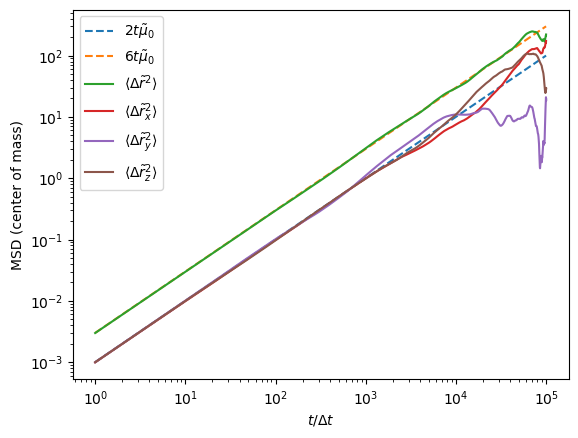

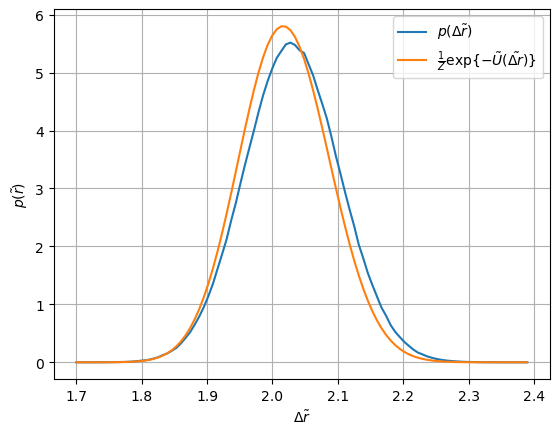

simulation time
20:37 min
Parameters: (0, 0, 20)


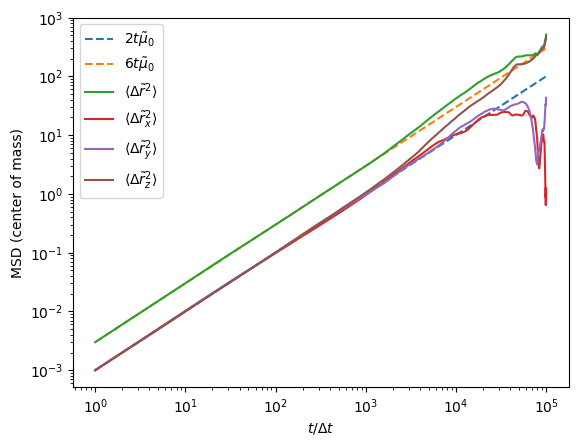

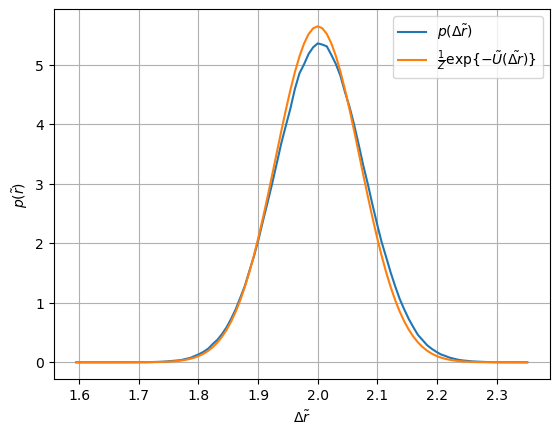

In [15]:
mobility = 0.0005
steps = 100000


param = ((0.25, 2.08, 20), (0, 0, 20))
for k, para in enumerate(param):
    # p1 = Polymer(n_beeds=n_beeds, mobility=mobility, q_beed=0, epsilon_LJ=0)
    
    eps = para[0]
    q = para[1]
    n_beeds = para[2]
    
    p1 = Polymer(n_beeds=n_beeds, mobility=mobility, epsilon_LJ=eps, q_beed=q)
    p1.create_chain(axis=1)

    t1 = time()
    p1.simulate(steps)
    t2 = time()
    print("simulation time")
    print(f"{(t2-t1)//60:.0f}:{(t2-t1)%60:2.0f} min")
    
    print("Parameters:", para)
    
    if k == 0:
        fname_top = f'polymer_{n_beeds:d}_beeds.pdb'
        fname_traj = f"traj_{n_beeds:d}beeds_{steps:d}frames_{mobility:.5f}mu.gro"

        # save trajectory in mdtraj to create .gro simulation trajectory
        topology = md.load(fname_top).topology
        trajectory = md.Trajectory(p1.trajectory, topology)

        # save as gromacs file
        trajectory.save_gro(filename=fname_traj)
        
        
    
    #p1.get_CM_MSD(plot=True)
    p1.get_CM_MSD(plot=True)
    p1.plot_distance_distribution()


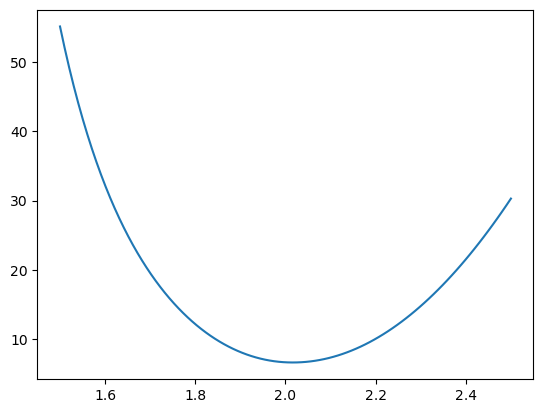

In [9]:
#plot analytical potential
r_U_an, U_an = p1.analytical_potential_function(np.linspace(1.5, 2.5, 100))

plt.figure()
plt.plot(r_U_an, U_an)

In [69]:
p = np.array([[-4.12135264, -0.19514491, -0.0458951 ],
              [-2.0338452,  -0.04587988, -0.12122903],
              [-0.26578863,  0.14098032, -0.0436622 ],
              [ 2.11211352, -0.01370567,  0.01043054],
              [ 4.03053548,  0.06536439,  0.10394412]])
#p = np.array(((0,0,0),(0,0,1)))

def rd(p, i, j):
    r = p[j]-p[i]
    d = np.sqrt(np.dot(r, r))
    return r, d

def f(r, d):
    return 200*(d-2)*r/d

r12, d12 = rd(p, 0, 1)
# print(d12)
# print(f(r12, d12))    

r21, d21 = rd(p, 1, 0)
r23, d23 = rd(p, 1, 2)

f21 = f(r21, d21)
f23 = f(r23, d23)

print(d21, d23)
print(f21)
print(f23)
print(f21+f23)

2.0941925800282783 1.7795947241381824
[-18.77837917  -1.34272831   0.6776738 ]
[-43.79525189  -4.62857901  -1.9213519 ]
[-62.57363106  -5.97130732  -1.2436781 ]


In [70]:
# r1 = p1.positions[0]
# r2 = p1.positions[1]

# print(r1)
# print(r2, "\n")

# r_vec = r2 - r1
# r = np.sqrt(np.dot(r_vec, r_vec))

# def f_NN(dr, direction):
#     return -2*100.0*(dr - 2*1.0)*direction/dr

# def f_LJ(dr, direction):
#     return -1*(-12*2**12/dr**13 + 6*2**7/dr**7)*direction/dr

# def f_Deb(dr, direction):
    
#     c_s = 10 # salt concentration in mM
#     q = 2.08 # dimensionless
#     lB = 3.077 # units of beed radii
#     A = q**2*lB
#     B = 1/(38.46153*c_s) # 1/(debye screening length) in units of beed radius
    
#     return A*(B+1/r)*np.exp(-B*r)*direction/r**2

# print(f_NN(r, r_vec))

In [16]:
# process trajectory using mdtraj

fname_top = f'polymer_{n_beeds:d}_beeds.pdb'
fname_traj = f"traj_{n_beeds:d}beeds_{steps:d}frames_{mobility:.5f}mu.gro"

# save trajectory in mdtraj to create .gro simulation trajectory
topology = md.load(fname_top).topology
trajectory = md.Trajectory(p1.trajectory, topology)

# save as gromacs file
trajectory.save_gro(filename=fname_traj)

# alternatively load traj from saved files
# trajectory = md.load(fname_traj, top=fname_top)

In [121]:
# alternatively load traj from saved files
topology = md.load_pdb(f"polymer_{n_beeds:d}_beeds.pdb", no_boxchk=True).topology
trajectory = md.Trajectory(p1.trajectory, topology)
#trajectory = md.load(fname_traj, top=f"polymer_{n_beeds:d}_beeds.pdb")


(20001, 20, 3)


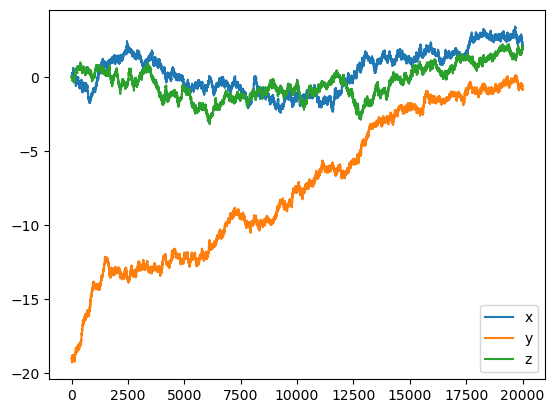

In [68]:
print(np.shape(traj_xyz))
plt.figure()
plt.plot(traj_xyz[:, 0, 0], label="x")
plt.plot(traj_xyz[:, 0, 1], label="y")
plt.plot(traj_xyz[:, 0, 2], label="z")
plt.legend()
plt.show()

In [14]:
# use numba parallelization to calculate msd faster

@njit
def calc_msd(traj_cm, n_frames, msd):
    for i in range(n_frames-1):
        #d0 = np.sqrt(np.dot(traj_cm[i], traj_cm[i]))
        # go over
        for j in range(i+1, n_frames):
            r = traj_cm[j] - traj_cm[i]
            d2 = np.dot(r, r)
            msd[j-i-1] += d2
            #n_msd[j-i-1] += 1 # change this to be a pre-defened array [n-1, n-2, ... , 1]
            
            
    msd = msd/np.arange(n_frames-1, 0, -1)
    return msd

In [15]:
@njit
def calc_msd_i(traj_cm, axis, n_frames, msd):
    for i in range(n_frames-1):
        #d0 = np.sqrt(np.dot(traj_cm[i], traj_cm[i]))
        # go over
        for j in range(i+1, n_frames):
            d2 = (traj_cm[j, axis] - traj_cm[i, axis])**2
            msd[j-i-1] += d2
            #n_msd[j-i-1] += 1
            
            
    msd = msd/np.arange(n_frames-1, 0, -1)
    return msd

In [17]:
# calculate msd, to check diffusion constant

n_beeds = p1.n_beeds
n_frames = len(p1.trajectory)
# n_frames = 20000

msd = np.zeros(n_frames-1)

traj_cm = list(())
#traj_xyz = trajectory.xyz
traj_xyz = p1.trajectory

#calculate trajectory for center of mass
for frame in traj_xyz:
    traj_cm.append(np.sum(frame, axis=0)/n_beeds)
    
traj_cm = np.array(traj_cm)

msd_fast = calc_msd(traj_cm, n_frames, msd)
msd_x = calc_msd_i(traj_cm, 0, n_frames, msd)
msd_y = calc_msd_i(traj_cm, 1, n_frames, msd)
msd_z = calc_msd_i(traj_cm, 2, n_frames, msd)





In [72]:
#calculate msd using mdtraj
def msd_mdtraj(trajectory):
    n_frames = len(trajectory)
    msd = np.zeros(n_frames-1)
    for k in range(n_frames-1):
        rmsds = md.rmsd(trajectory[k+1:], trajectory[k:], 0)
        msd[:n_frames-k-1] += rmsds**2
    msd = msd/np.arange(n_frames-1, 0, -1)
    return msd

def msd_mdtraj_i(trajectory, i):
    n_frames = len(trajectory)
    msd = np.zeros(n_frames-1)
    for k in range(n_frames-1):
        rmsds = md.rmsd(trajectory[k+1:, i], trajectory[k:, i], 0)
        msd[:n_frames-k-1] += rmsds**2
    msd = msd/np.arange(n_frames-1, 0, -1)
    return msd


# msd_mdt = msd_mdtraj(trajectory)

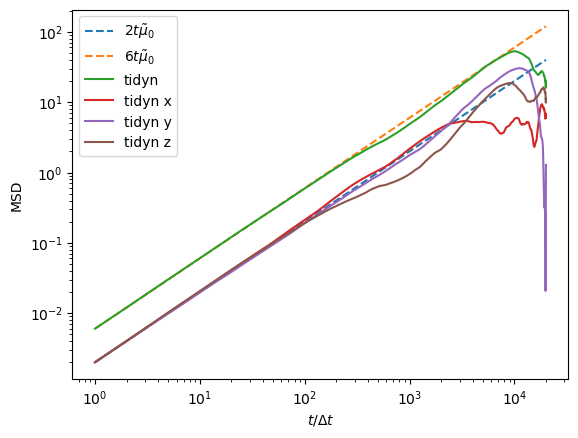

In [78]:
msd_tid = tid.msd(traj_cm)
msd_tid_x = tid.msd(traj_cm[:,0])
msd_tid_y = tid.msd(traj_cm[:,1])
msd_tid_z = tid.msd(traj_cm[:,2])

t = np.arange(n_frames)

plt.figure()
#plt.loglog(t[1:], msd_fast, label=r"$\langle \Delta\tilde{r}^2\rangle$")
#plt.loglog(t[1:], msd_x, label=r"$\langle \Delta\tilde{r}_x^2\rangle$")
#plt.loglog(t[1:], msd_y, label=r"$\langle \Delta\tilde{r}_y^2\rangle$")
#plt.loglog(t[1:], msd_z, label=r"$\langle \Delta\tilde{r}_z^2\rangle$")
#plt.loglog(t[1:], msd_x+msd_y+msd_z, label="1+2+3")
plt.loglog(t[1:], 2*t[1:]*mobility, label=r"$2t\tilde{\mu}_0$", linestyle="--")
plt.loglog(t[1:], 6*t[1:]*mobility, label=r"$6t\tilde{\mu}_0$", linestyle="--")
#plt.loglog(t[1:], msd_mdt, label="mdtraj")
plt.loglog(t[1:], msd_tid[1:]*n_beeds, label="tidyn")
plt.loglog(t[1:], msd_tid_x[1:]*n_beeds, label="tidyn x")
plt.loglog(t[1:], msd_tid_y[1:]*n_beeds, label="tidyn y")
plt.loglog(t[1:], msd_tid_z[1:]*n_beeds, label="tidyn z")
plt.xlabel(r"$t/\Delta t$")
plt.ylabel("MSD")
plt.legend()
plt.show()

In [79]:
# calculate radius of gyration 

deviation_cm = np.zeros((p1.n_beeds))
for frame, r_cm in zip(p1.trajectory, traj_cm):
    deviation_cm += np.sum((frame-r_cm)**2, axis=1)

Rg = np.sqrt(np.sum(deviation_cm/n_frames)/p1.n_beeds)

print(Rg)
    

6.265390878155055


In [34]:
    

def analytical_potential(r, polymer):
    K = polymer.force_constant_nn
    r0 = polymer.r0_beeds
    epsilon = polymer.epsilon_LJ 
    sigma = polymer.sigma_LJ
    q = polymer.q_beed
    lB = polymer.lB_debye
    L_s = 1/(38.46153*polymer.c_S)
    
    u_nn = K*(r-r0)**2
    u_LJ = 4*epsilon*(sigma**12/r**12 - sigma**7/r**6 + 1)
    u_Deb = q**2*lB*np.exp(-L_s*r)/r
   
    return u_nn #+ u_LJ + u_Deb


In [123]:
# # compute mdtraj pair list
# mdtraj_pairs = list(())

# for i in range(n_beeds-1):
#     for j in range(i+1, n_beeds):
#         mdtraj_pairs.append((i, j))

# # mdtraj rdf
# rdf_mdtraj_r, rdf_mdtraj_g = md.compute_rdf(trajectory, mdtraj_pairs, r_range=(1.5, 2.5), bin_width=0.01, periodic=False)

In [42]:
# calculate distribution of distances between two neighbouring beeds
n_beeds = p1.n_beeds
distances_nn = list(())
diff = 7 # number of beeds on the two ends of the chain that shouldnt be included
for frame in p1.trajectory:
    distances_nn.append(np.sqrt(np.sum((frame[diff:n_beeds-1-diff] - frame[1+diff:n_beeds-diff])**2, axis=1)))

distances_nn = np.array(distances_nn).ravel()

print(np.min(distances_nn))
print(np.max(distances_nn))

n_bins = 200
bin_interval = (np.min(distances_nn), np.max(distances_nn))
#bin_interval = (1.0, 3.5)

histogram_nn, edges_nn = np.histogram(distances_nn, bins=n_bins, range=bin_interval, density=True)

1.6675521593300155
2.3590286563901346


201


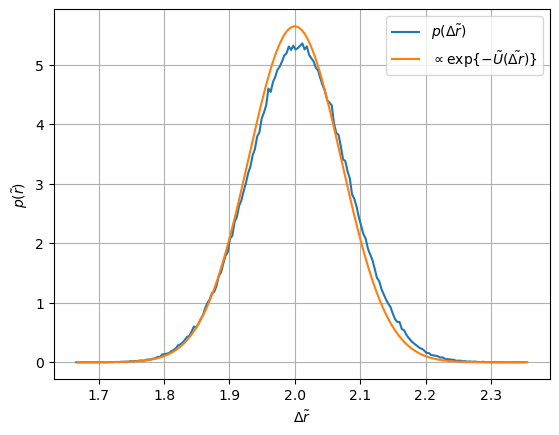

In [44]:
E_pot = analytical_potential(edges_nn[:n_bins], p1)
E_pot_normalize = np.sum((edges_nn[1:]-edges_nn[:n_bins])*np.exp(-E_pot))
print(len(edges_nn))

plt.figure()
plt.plot(edges_nn[:n_bins] - (edges_nn[1]-edges_nn[0])/2, histogram_nn, label=r"$p(\Delta\tilde{r})$")
plt.plot(edges_nn[:n_bins], np.exp(-E_pot)/E_pot_normalize, label=r"$\propto\mathrm{exp}\{-\tilde{U}(\tilde{\Delta r})\}$")
#plt.plot(edges_nn, 1/(2*np.sqrt(2))*E_pot**2*np.exp(-E_pot**2)*2.5e18, label="pdf")
plt.legend()
plt.xlabel(r"$\Delta\tilde{r}$")
plt.ylabel(r"$p(\tilde{r})$")
plt.grid()
plt.show()
